The lab material presented here is based on the data provided by the [OpenFlights](https://openflights.org/data.html) dataset that contains information on airports, airlines and routes.

The [OpenFlights](https://openflights.org/data.html) dataset contains the ''Airport database'' that provides information for over 10,000 airports, train stations and ferry terminals spanning the globe. Each entry contains the following information:
* **Airport ID** - Unique OpenFlights identifier for this airport.
* **Name** - Name of airport. May or may not contain the City name.
* **City** - Main city served by airport. May be spelled differently from Name.
* **Country** - Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
* **IATA** - 3-letter IATA code. Null if not assigned/unknown.
* **ICAO** - 4-letter ICAO code. Null if not assigned.
* **Latitude** - Decimal degrees, usually to six significant digits. Negative is South, positive is North.
* **Longitude** - Decimal degrees, usually to six significant digits. Negative is West, positive is East.
* **Altitude** - In feet.
* **Timezone** - Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
* **DST** - Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
* **Tz database time zone** - Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
* **Type** - Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
* **Source** - Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.

The data is UTF-8 (Unicode) encoded.

The [OpenFlights](https://openflights.org/data.html) dataset also contains the ''Route database'' which provides information for 59036 routes between 3209 airports on 531 airlines spanning the globe. Each entry contains the following information:
* **Airline** - 2-letter (IATA) or 3-letter (ICAO) code of the airline.
* **Airline ID** - Unique OpenFlights identifier for airline (see Airline).
* **Source airport** - 3-letter (IATA) or 4-letter (ICAO) code of the source airport.
* **Source airport ID** - Unique OpenFlights identifier for source airport (see Airport)
* **Destination airport** - 3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
* **Destination airport ID** - Unique OpenFlights identifier for destination airport (see Airport)
* **Codeshare** - "Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
* **Stops** - Number of stops on this flight ("0" for direct)
* **Equipment** - 3-letter codes for plane type(s) generally used on this flight, separated by spaces

The data is ISO 8859-1 (Latin-1) encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

## Airport dataset

We start by retrieving the dataset directly from the web using [urllib](https://docs.python.org/3/library/urllib.html) method from the standard python library.

In [1]:
import urllib.request
url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'
u = urllib.request.urlopen(url)
rawdata = u.read()

We store the information retrieved to a local file so that we can work with the data without the need to re-download again and again. 

In [2]:
localFile = open("airports.dat", "wb")
localFile.write(rawdata)
localFile.close()

The files retrieved follows a comma-separated format, so once again we use the [CSVREADER](https://docs.python.org/2/library/csv.html) a standard python package as explained in [Reading and writing comma-separated data](http://opentechschool.github.io/python-data-intro/core/csv.html). 

Notice that since the file is using [UTF-8 encoding](https://en.wikipedia.org/wiki/UTF-8) we need to specify this when using the _open_ method.

In [3]:
import csv 

errors = 0
f = open("airports.dat", encoding='utf8')
airports = []
for row in csv.reader(f, delimiter=','):
    thisLine = []
    try:
        thisLine.append(int(row[0])) # Airport ID
        thisLine.append(row[1]) # Airport Name
        thisLine.append(row[2]) # City
        thisLine.append(row[3]) # Country
        thisLine.append(row[4]) # IATA/FAA Code
        thisLine.append(row[5]) # ICAO Code
        thisLine.append(float(row[6])) # Latitude
        thisLine.append(float(row[7])) # Longitude
        thisLine.append(float(row[8])) # Altitude
        thisLine.append(float(row[9])) # Timezone offset from UTC
        thisLine.append(row[10]) # Daylight savings code
        thisLine.append(row[11]) # Timezone
        thisLine.append(row[12]) # Type
        thisLine.append(row[13]) # Source

    except :
        errors += 1
        
    else:
        airports.append(thisLine)
        
print("Loaded", len(airports), "airports. Encountered", errors, "errors")

Loaded 6874 airports. Encountered 310 errors


## Routes dataset

We will now proceed by downloading and parsing the routes dataset.

In [4]:
url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat'
u = urllib.request.urlopen(url)
rawdata = u.read()
localFile = open("routes.dat", "wb")
localFile.write(rawdata)
localFile.close()

In [5]:
errors = 0
f = open("routes.dat")
routes = []
for row in csv.reader(f):
    thisLine = []
    try:
        thisLine.append(row[0]) # IATA code
        thisLine.append(int(row[1])) # Airline ID
        thisLine.append(int(row[3])) # Source Airport ID
        thisLine.append(int(row[5])) # Destination Airport ID
        thisLine.append(int(row[7])) # Number of stops
        thisLine.append(row[8]) # Plane type        
        
    except :
        errors += 1
        
    else:
        routes.append(thisLine)
        
print("Loaded", len(routes), "routes. Encountered", errors, "errors")

Loaded 66765 routes. Encountered 898 errors


## Data as a Graph  

We will use the [networkX](http://networkx.github.io/) library to represent the dataset as a graph. We will represent each airport with a node in the graph. For each route connecting two airports, we will use an edge connecting the corresponding nodes.

In [6]:
import networkx as nx
G = nx.Graph()

### Inserting Nodes

We will use the ID of the airport as the main identifier of the node in the Directed Graph.

[networkX](http://networkx.github.io/) allows us to attach labels to each node and edge of the Graph. We will use this feature to store the information provided by the dataset.

In [7]:
for row in airports:
    G.add_node(row[0], id=row[0], 
               name=row[1], city=row[2], country=row[3],
               iata=row[4], icao=row[5],
               lat=row[6], long=row[7], alt=row[8],
               utc_offset=row[9], daylight=row[10], timezone=row[11],
               type=row[12], source=row[13])

### Inserting Edges

In a similar way we insert the edges in the Directed Graph.

Due to some errors occured while loading the airport dataset, some airports are missing. When we use the _add__edge_ method, if the nodes do not exist, they will be created at that point. These automatically created nodes will not have any labels attached. This may create some problems later on. So we will exclude all routes that involve an airport that is not loaded.

In [8]:
f = open("routes.dat")
for row in routes:    
    if row[2] in G.nodes() and row[3] in G.nodes():
        G.add_edge(row[2], row[3], 
                   airline=row[0], airlineID=row[1],
                  stops=row[4], aircraft=[5])

### Retrieving Nodes and Edges

Retrieving a node is done very easily based on the hashable value provided (in our case, the ID of the airport)

In [9]:
G.nodes[1555]

{'alt': 13.0,
 'city': 'Rome',
 'country': 'Italy',
 'daylight': 'E',
 'iata': 'FCO',
 'icao': 'LIRF',
 'id': 1555,
 'lat': 41.8002778,
 'long': 12.2388889,
 'name': 'Leonardo da Vinci–Fiumicino Airport',
 'source': 'OurAirports',
 'timezone': 'Europe/Rome',
 'type': 'airport',
 'utc_offset': 1.0}

Similarly we can retrieve an edge by providing the ID of the source and destination node.

In [10]:
G.edges[1555,1550]

{'aircraft': [5], 'airline': 'AZ', 'airlineID': 596, 'stops': 0}

We can retrieve the list of neighboring nodes (i.e., those nodes of the graph with which there exists an edge) using the _neighbors_ iterator as follows:

In [11]:
list(G.neighbors(1555))

[1536,
 2560,
 1538,
 2564,
 3077,
 1665,
 1545,
 469,
 1550,
 1551,
 273,
 3093,
 534,
 2072,
 1561,
 1562,
 1563,
 3930,
 3973,
 1056,
 2082,
 2851,
 3876,
 1382,
 3885,
 302,
 4317,
 1074,
 1587,
 478,
 1590,
 1335,
 1759,
 1852,
 1418,
 3959,
 580,
 1606,
 1353,
 1354,
 1613,
 3406,
 1359,
 337,
 1107,
 340,
 1520,
 342,
 599,
 344,
 345,
 346,
 350,
 351,
 352,
 609,
 3682,
 1636,
 3941,
 1638,
 1128,
 2922,
 231,
 591,
 146,
 3953,
 893,
 629,
 1655,
 3448,
 1657,
 2170,
 2939,
 3964,
 1514,
 1905,
 2176,
 2177,
 3714,
 2179,
 2948,
 1157,
 490,
 3494,
 2954,
 2988,
 2188,
 1678,
 1423,
 2945,
 248,
 3988,
 3992,
 1435,
 3484,
 1386,
 2975,
 636,
 1051,
 1701,
 1190,
 679,
 3752,
 2985,
 1194,
 517,
 687,
 1200,
 1489,
 668,
 521,
 1206,
 3316,
 1486,
 287,
 1212,
 4029,
 1909,
 1216,
 193,
 1218,
 3076,
 1526,
 1735,
 1737,
 1739,
 1229,
 1230,
 1741,
 3024,
 1528,
 210,
 675,
 3797,
 1273,
 3364,
 644,
 1501,
 1246,
 421,
 737,
 1506,
 1508,
 1509,
 2279,
 1512,
 502,
 4330,
 2

We can get additional information for a specific node through the info function:

In [12]:
nx.info(G, 1555)

'Node 1555 has the following properties:\nDegree: 160\nNeighbors: 1536 2560 1538 2564 3077 1665 1545 469 1550 1551 273 3093 534 2072 1561 1562 1563 3930 3973 1056 2082 2851 3876 1382 3885 302 4317 1074 1587 478 1590 1335 1759 1852 1418 3959 580 1606 1353 1354 1613 3406 1359 337 1107 340 1520 342 599 344 345 346 350 351 352 609 3682 1636 3941 1638 1128 2922 231 591 146 3953 893 629 1655 3448 1657 2170 2939 3964 1514 1905 2176 2177 3714 2179 2948 1157 490 3494 2954 2988 2188 1678 1423 2945 248 3988 3992 1435 3484 1386 2975 636 1051 1701 1190 679 3752 2985 1194 517 687 1200 1489 668 521 1206 3316 1486 287 1212 4029 1909 1216 193 1218 3076 1526 1735 1737 1739 1229 1230 1741 3024 1528 210 675 3797 1273 3364 644 1501 1246 421 737 1506 1508 1509 2279 1512 502 4330 2983 492 1517 1519 1264 1524 3830 503 3576 1529 507 4309'

We can retrieve the attributes (labels) of nodes and edges following the style of accessing data in dictionary. 

In [13]:
G.nodes[1555]['lat']

41.8002778

In [14]:
G.edges[1555,1550]['airline']

'AZ'

In a similar way like dictionaries we can add new entries and update the values of existing.

In [15]:
G.nodes[1555]['color'] = 'blue'

In [16]:
G.nodes[1555]['color']

'blue'

In [17]:
G.nodes[1555]['color'] = 'red'

In [18]:
G.nodes[1555]['color']

'red'

### Graph Properties

[networkX](http://networkx.github.io/) provides algorithms for computing various metrics of the graph structure.

In [19]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 6874\nNumber of edges: 18438\nAverage degree:   5.3646'

In [20]:
nx.density(G)

0.0007805270068567253

In [21]:
nx.is_connected(G)

False

We can measure the centrality of the nodes (also the betweeness centrality, etc.)

In [22]:
centrality = nx.degree_centrality(G)

We can now update the graph by adding the centrality measure as label of the nodes.

In [24]:
for node,value in centrality.items():
    G.nodes[node]['centrality'] = value

In [25]:
G.nodes[1555]['centrality']

0.023279499490760948

We can also check whether two nodes are connected by a path of edges or not using the _has__path_ method.

In [26]:
nx.has_path(G, source=1555, target=3416)

False

In [27]:
nx.has_path(G, source=1555, target=18)

True

In order to identify the disconnected nodes (and remove them, since there are no routes connecting them) we can the _DegreeView_ provided by networkx. The _DegreeView_ provides an iterator for (node, degree) as well as lookup for the degree for a single node.

In [28]:
list(G.degree())

[(1, 4),
 (2, 7),
 (3, 9),
 (4, 9),
 (5, 32),
 (6, 4),
 (7, 5),
 (8, 8),
 (9, 7),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 0),
 (14, 0),
 (15, 1),
 (16, 34),
 (17, 0),
 (18, 4),
 (19, 0),
 (20, 0),
 (21, 4),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 3),
 (28, 1),
 (29, 4),
 (30, 3),
 (31, 1),
 (32, 4),
 (33, 2),
 (34, 2),
 (35, 0),
 (36, 0),
 (37, 3),
 (38, 0),
 (39, 0),
 (40, 2),
 (41, 4),
 (42, 0),
 (43, 0),
 (44, 0),
 (45, 4),
 (46, 0),
 (47, 0),
 (48, 0),
 (49, 35),
 (50, 3),
 (51, 0),
 (52, 0),
 (53, 0),
 (54, 2),
 (55, 10),
 (56, 4),
 (57, 0),
 (58, 3),
 (59, 0),
 (60, 1),
 (61, 1),
 (62, 0),
 (63, 2),
 (64, 0),
 (65, 1),
 (66, 0),
 (67, 4),
 (68, 1),
 (69, 3),
 (70, 4),
 (71, 0),
 (72, 3),
 (73, 32),
 (74, 0),
 (75, 2),
 (76, 0),
 (77, 0),
 (78, 2),
 (79, 2),
 (80, 0),
 (81, 0),
 (82, 0),
 (83, 0),
 (84, 0),
 (85, 0),
 (86, 0),
 (87, 10),
 (88, 0),
 (89, 0),
 (90, 7),
 (91, 0),
 (92, 0),
 (93, 0),
 (94, 3),
 (95, 0),
 (96, 0),
 (97, 0),
 (98, 0),
 (99, 0),
 (100, 26),
 

### Graph Manipulation & Subgraphs

Using the _DegreeView_, we will iterate the nodes of the graph and remove those with degree 0 (i.e., the disconnected nodes).

In [29]:
for node, degree in list(G.degree()):
    if degree == 0:
        G.remove_node(node)

From the original 6874, 3772 were deleted.

In [30]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 3102\nNumber of edges: 18438\nAverage degree:  11.8878'

Now we can recheck if the node is connected.

In [31]:
nx.is_connected(G)

False

Since all nodes are connected to atleast another node, and the graph is still not connected, then there must be more than 1 connected component. We can use the _number__connected_ __components_ method of networkx to answer this question.

In [32]:
nx.number_connected_components(G)

7

We can now use the _connected__components_ method to access these 7 connected components.

In [33]:
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[3077, 10, 4, 4, 3, 2, 2]

Clearly the first connected component contains the vast majority of the nodes, while the other 6 contain very few nodes. We can access this also using the *max* method in a much more efficient way than the *sort* method.

In [34]:
largest_cc = max(nx.connected_components(G), key=len)

We can now create a new graph containing only the nodes (and corresponding edges) that participate in the largest connected component. 

In [35]:
Gcon = G.subgraph(largest_cc)

In [36]:
nx.info(Gcon)

'Name: \nType: SubGraph\nNumber of nodes: 3077\nNumber of edges: 18414\nAverage degree:  11.9688'

### Graph Drawing

We can generate various plots for the graphs using the [matplotlib](http://matplotlib.org/) module.

In [37]:
import matplotlib.pyplot as plt

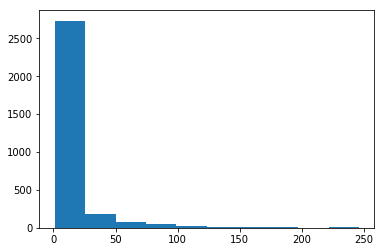

In [38]:
plt.clf()
plt.figure()
plt.hist([degree for node, degree in list(G.degree())], bins=10)
plt.show()

We can plot the nodes based on their latitude and longitude. To do so, we create a new label of the format (x,y).

In [39]:
for node in Gcon.nodes():
    Gcon.node[node]['pos']=(Gcon.node[node]['long'], Gcon.node[node]['lat'])

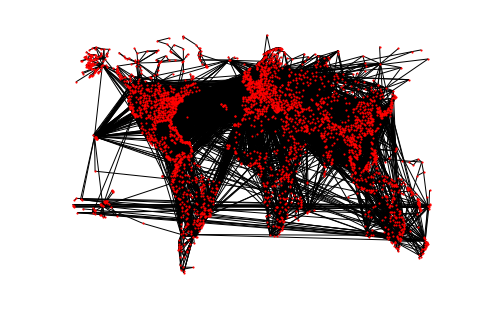

In [40]:
plt.clf()
nx.draw(Gcon, nx.get_node_attributes(Gcon,'pos'), node_shape='.', node_size=5)
plt.show()

networkX provides additional methods to draw the nodes and the edges of the network with broader options.

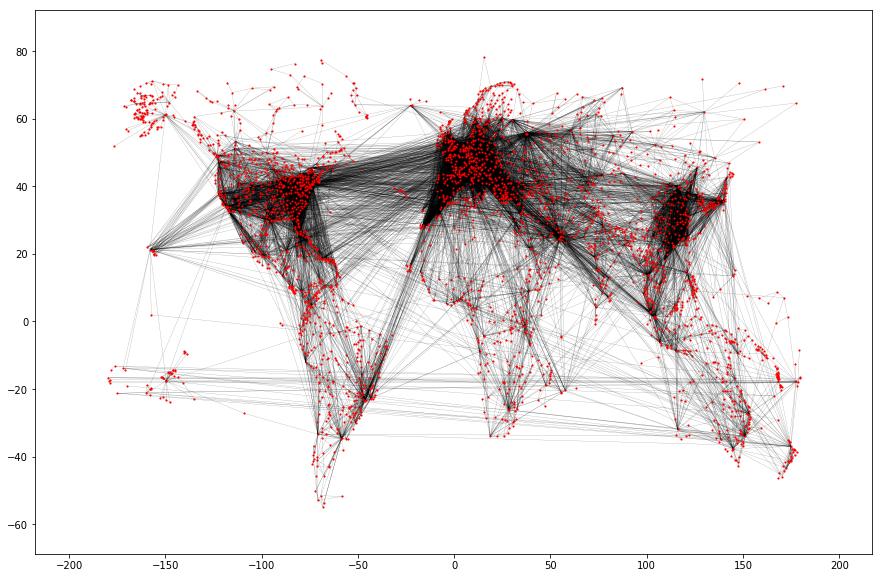

In [41]:
plt.clf()
plt.figure(figsize=(15,10))
nx.draw_networkx_edges(Gcon, nx.get_node_attributes(Gcon,'pos'), width=0.2, alpha=0.5)
nx.draw_networkx_nodes(Gcon, nx.get_node_attributes(Gcon,'pos'), node_shape='.', node_size=5)
plt.show()

We can assign different colors to countries by introducing a new attribute (color). Similarly we can modify the size of the nodes based on the centrality measure.

In [42]:
maxCentrality = max(centrality.values())
for node in Gcon.nodes():
    if Gcon.nodes[node]['timezone'].find('Europe') == 0:
        Gcon.nodes[node]['color'] = 'blue'
        
    elif Gcon.nodes[node]['timezone'].find('Africa') == 0:
        Gcon.nodes[node]['color'] = 'green'

    else:
        Gcon.nodes[node]['color'] = 'grey'
        
    if Gcon.nodes[node]['centrality'] >= maxCentrality*.9:
        Gcon.nodes[node]['size'] = 500
    elif Gcon.nodes[node]['centrality'] >= maxCentrality*.5:
        Gcon.nodes[node]['size'] = 100
    else:
        Gcon.nodes[node]['size'] = 5

Similarly we can assign different colors to routes of specific airlines.

In [43]:
for edge in Gcon.edges():
    if (Gcon[edge[0]][edge[1]]['airline'] == 'LH'):
        Gcon[edge[0]][edge[1]]['color'] = 'red'
        Gcon[edge[0]][edge[1]]['size'] = 2
    
    elif (Gcon[edge[0]][edge[1]]['airline'] == 'US'):
        Gcon[edge[0]][edge[1]]['color'] = 'blue'
        Gcon[edge[0]][edge[1]]['size'] = 2
    
    else:
        Gcon[edge[0]][edge[1]]['color'] = 'grey'
        Gcon[edge[0]][edge[1]]['size'] = 0.2

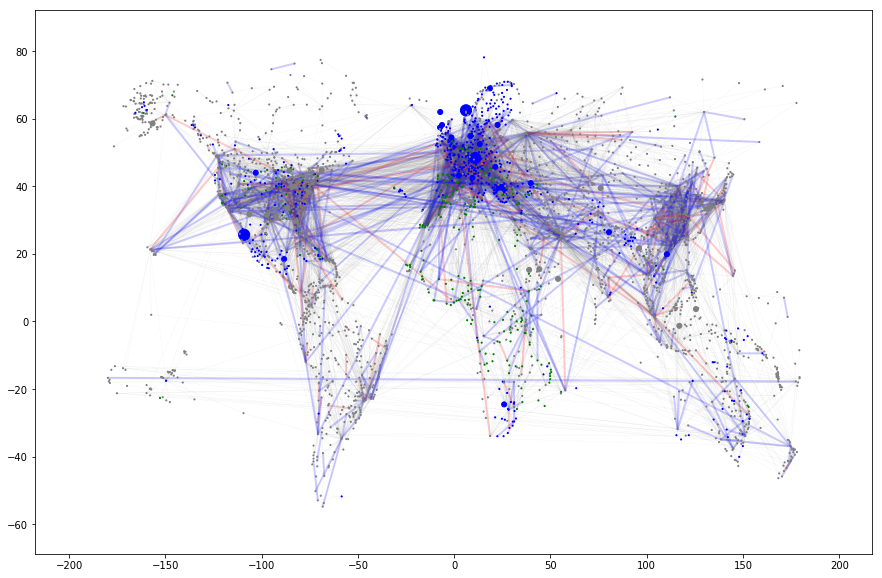

In [44]:
plt.clf()
plt.figure(figsize=(15,10))
nx.draw_networkx_edges(Gcon, nx.get_node_attributes(Gcon,'pos'), 
                       alpha=0.2,
                       width=[v for v in nx.get_edge_attributes(Gcon,'size').values()],
                       edge_color=[v for v in nx.get_edge_attributes(Gcon,'color').values()])
nx.draw_networkx_nodes(Gcon, nx.get_node_attributes(Gcon,'pos'), 
                       node_shape='.', 
                       node_size=[v for v in nx.get_node_attributes(Gcon,'size').values()],
                       node_color=[v for v in nx.get_node_attributes(Gcon,'color').values()])
plt.show()